# NEURAL NETWORKS AND DEEP LEARNING
# HOMEWORK 1

**Giovanni Gazzola** <br>
**mtr:1227160**

## Libraries

In [ ]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sas

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms



In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
#set random seeds
torch.manual_seed(1227160)
np.random.seed(1227160)

# Classification task


##Dataset

In [ ]:
#download the dataset
train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)

In [ ]:
#define the class CsvDataset to get the datasets 
class CsvDataset(Dataset):

  def __init__(self, file_name = None, transform=None):
    
    self.transform = transform
    # creation of DataFrames containing the whole dataset split in train and test
    if file_name == None:
      self.data = pd.DataFrame()
    else:
      self.data = pd.DataFrame(file_name)
      self.data.rename(columns={ self.data.columns[-1]: "Label" }, inplace = True)

  def __len__(self):
    # return the rows of the dataset
    return self.data.shape[0]

  def __getitem__(self, index):
    # return the specified row sample
    sample = np.array(self.data.iloc[index])
    
    if self.transform:
        sample = self.transform(sample)
    return sample

Shape of the train set:  (60000, 785)
Shape of the test set:  (10000, 785) 




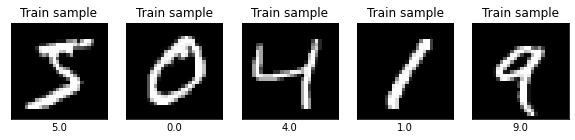

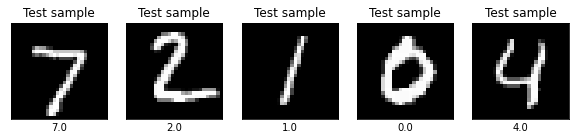

In [ ]:
#store all the images as a single array with size = (1,width*height)
#the last element of the array will be the label relative to that image
all_training_sample = []
all_test_sample = []
width = train_dataset[0][0].size[0]
heigth = train_dataset[0][0].size[1]

for item in train_dataset:
  image = np.array(item[0]).reshape(1,width*heigth)/255
  all_training_sample.append(np.append(image[0],item[1]))

for item in test_dataset:
  image = np.array(item[0]).reshape(1,width*heigth)/255
  all_test_sample.append(np.append(image[0],item[1]))

# creation of CsvDataset objects containing DataFrames for both train and test datasets
df_train = CsvDataset(all_training_sample)
df_test = CsvDataset(all_test_sample)

#display the shape of both sets
print("Shape of the train set: ", df_train.data.shape)
print("Shape of the test set: ", df_test.data.shape,"\n\n")

#display some samples of the training and test sets
plt.figure(figsize=(10,5))

for i in range(1, 6):
    plt.subplot(2,5,i)
    plt.xticks([])
    plt.yticks([])
    plt.title("Train sample")
    

    label = df_train.__getitem__(i-1)[width*heigth]
    plt.imshow(df_train.__getitem__(i-1)[0:width*heigth].reshape((width, heigth)), cmap='gray')
    plt.xlabel(label)

plt.figure(figsize=(10,5))

for i in range(1, 6):
    plt.subplot(2,5,i)
    plt.xticks([])
    plt.yticks([])
    plt.title("Test sample")
    

    label = df_test.__getitem__(i-1)[width*heigth]
    plt.imshow(df_test.__getitem__(i-1)[0:width*heigth].reshape((width, heigth)), cmap='gray')
    plt.xlabel(label)


##Transform

In [ ]:
#create a class to convert sample to Tensors
class ToTensor_conv(object):
    #Convert sample to Tensors
    def __call__(self, sample):
        #return the values of the images normalized and of type Float
        x = sample[0:sample.size-1]
        x = torch.tensor(np.array(x).reshape(width,heigth)).float() 

        #return the label for each image of type Long
        y =  torch.tensor(sample[sample.size-1]).long()     
        
        return (x,y)


class ToTensor_linear(object):
    #Convert sample to Tensors
    def __call__(self, sample):
        x = sample[0:sample.size-1]
        x = torch.tensor(x).float() 
        y =  torch.tensor(sample[sample.size-1]).long() 

        return (x,y)


In [ ]:
#apply the transformation over the samples of both the datasets
#first for CNNs
composed_transform = transforms.Compose([ToTensor_conv()])
#then for FFNN
composed_transform_linear = transforms.Compose([ToTensor_linear()])

#get the transformed dataset for FCNN
train_dataset_linear = CsvDataset(all_training_sample, transform=composed_transform_linear)

#get the transformed dataset for CNNs
train_dataset = CsvDataset(all_training_sample, transform=composed_transform)
test_dataset = CsvDataset(all_test_sample, transform=composed_transform)

##Validation set and DataLoader

Split the training set into training set and validation set.
The validation set is choose to be 20% of the entire training set after shuffling it.

In [ ]:
alpha = 0.2
m_training = train_dataset.__len__()

#shuffle the training set
train_dataset.data = train_dataset.data.sample(frac=1).reset_index(drop=True)

#split the training set into training set and validation set
size_val = int(alpha*m_training)
size_tr = int(m_training - size_val)

#initialize the new CsvDataset empty objects
tr_dataset = CsvDataset(transform=composed_transform)
val_dataset = CsvDataset(transform=composed_transform)

#split
tr_dataset.data = train_dataset.data[0:size_tr]
val_dataset.data = train_dataset.data[m_training-size_val:m_training]

print("Shape of the training set without the validation set: ", tr_dataset.data.shape)
print("Shape of the validation set: ", val_dataset.data.shape)

#repeat the procedure for the linear model
tr_dataset_linear = CsvDataset(transform=composed_transform_linear)
val_dataset_linear = CsvDataset(transform=composed_transform_linear)

tr_dataset_linear.data = train_dataset_linear.data[0:size_tr]
val_dataset_linear.data = train_dataset_linear.data[m_training-size_val:m_training]

Shape of the training set without the validation set:  (48000, 785)
Shape of the validation set:  (12000, 785)


Create the DataLoader:


*   defined batch size
*   defined if shuffle the data

In [ ]:
#for CNNs
train_dataloader = DataLoader(tr_dataset, batch_size=2000, shuffle=True, num_workers=0)
val_dataloader  = DataLoader(val_dataset,  batch_size=val_dataset.__len__(), shuffle=False, num_workers=0)

In [ ]:
#for FCNN
train_dataloader_linear = DataLoader(tr_dataset_linear, batch_size=2000, shuffle=True, num_workers=0)
val_dataloader_linear  = DataLoader(val_dataset_linear,  batch_size=val_dataset_linear.__len__(), shuffle=False, num_workers=0)

## Networks Definition and Comparison

### Models with different architecture

In [ ]:
#class for Fully Connected Neural Network
class Net_linear(nn.Module):
  def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = nn.ReLU()
        
  def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.out(x)
        return x

#class for convolutional network with dropout layers
class Net(nn.Module):
  def __init__(self, Ni, Nh1, Nh2, Nl1, Nl2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st convolutional layer
        Nl1 - Neurons in the 1st linear layer
        Nl2 - Neurons in the 2nd linear layer
        No - Output size
        """
        super().__init__()
        
        print('Network initialized')
        self.fc1 = nn.Conv2d(Ni, Nh1, 5, padding = 2)
        self.max1 = nn.MaxPool2d(2, padding = 1)
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Conv2d(Nh1, Nh2, 3, padding = 1)
        self.max2 = nn.MaxPool2d(2, padding = 1)
        self.drop2 = nn.Dropout(0.5)
        self.fc3 = nn.Flatten()
        self.fc4 = nn.Linear(in_features=Nl1, out_features=Nl2)
        self.out = nn.Linear(in_features=Nl2, out_features=No)
        self.act = nn.ReLU()
        
  def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        #print(x.shape)
        x = self.max1(x)
        x = self.drop1(x)
        #print(x.shape)
        x = self.act(self.fc2(x))
        x = self.max2(x)
        x = self.drop2(x)
        #print(x.shape)
        x = self.act(self.fc3(x))
        #print(x.shape)
        x = self.act(self.fc4(x))
        x = self.out(x)
        return x

#class for convolutional network without dropout layers
class Net_no_drop(nn.Module):
  def __init__(self, Ni, Nh1, Nh2, Nl1, Nl2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st convolutional layer 
        Nl1 - Neurons in the 1st linear layer
        Nl2 - Neurons in the 2nd linear layer
        No - Output size
        """
        super().__init__()
        
        print('Network initialized')
        self.fc1 = nn.Conv2d(Ni, Nh1, 5, padding = 1)
        self.max1 = nn.MaxPool2d(2, padding = 1)
        self.fc2 = nn.Conv2d(Nh1, Nh2, 3, padding = 1)
        self.max2 = nn.MaxPool2d(2, padding = 1)
        self.fc3 = nn.Flatten()
        self.fc4 = nn.Linear(in_features=Nl1, out_features=Nl2)
        self.out = nn.Linear(in_features=Nl2, out_features=No)
        self.act = nn.ReLU()
        
  def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        #print(x.shape)
        x = self.max1(x)
        x = self.act(self.fc2(x))
        x = self.max2(x)
        #print(x.shape)
        x = self.act(self.fc3(x))
        #print(x.shape)
        x = self.act(self.fc4(x))
        x = self.out(x)
        return x

In [ ]:
#initialize FCNN network
Ni = width*heigth
Nh1 = 64
Nh2 = 128
No = 10

linear = Net_linear(Ni, Nh1, Nh2, No)

#initialize CNN networks
Ni = 1
Nh1 = 8
Nh2 = 16
Nl1 = Nh2*8*8 
Nl2 = 64
No = 10

conv_drop = Net(Ni, Nh1, Nh2, Nl1, Nl2, No)
conv_no_drop = Net_no_drop(Ni, Nh1, Nh2, Nl1, Nl2, No)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

linear.to(device)
conv_drop.to(device)
conv_no_drop.to(device)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
optimizer_linear =  optim.Adam(linear.parameters(), lr=1e-3)
optimizer_conv_drop = optim.Adam(conv_drop.parameters(), lr=1e-3)
optimizer_conv_no_drop = optim.Adam(conv_no_drop.parameters(), lr=1e-3)

#create a list which elements point to one of the network created
networks = [linear, conv_drop, conv_no_drop]

#create a list containing the optimizer for each model
optimizers = [optimizer_linear, optimizer_conv_drop, optimizer_conv_no_drop]

Network initialized
Network initialized
Network initialized
Training device: cuda


In [ ]:
epochs = [35, 80, 25]
all_train_loss = []
all_val_loss = []
all_acc_train = []
all_acc_val = []

for k in range(0,len(networks)):     
    print("MODEL", k+1 ,"\n")
    
    if k == 0:
      tr_dataloader = train_dataloader_linear
      vl_dataloader = val_dataloader_linear
    else:
      tr_dataloader = train_dataloader
      vl_dataloader = val_dataloader


    ### TRAINING LOOP
    num_epochs = epochs[k]
    acc_train = 0
    acc_val = 0
    train_loss_log = []
    val_loss_log = []
    for epoch_num in range(num_epochs):
        ### TRAIN
        acc_t = []
        acc_v = []
        train_loss= []
        # Training mode (e.g. enable dropout)
        networks[k].train()
        for sample_batched in tr_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)

            if k != 0:
              x_batch = x_batch.unsqueeze(1)

            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = networks[k](x_batch)
            
            # Compute loss
            loss = loss_fn(out, label_batch)

            # Backpropagation
            networks[k].zero_grad()
            loss.backward()

            # Update the weights
            optimizers[k].step()

            # Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)

            #get the accuracy for this batch
            pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
            right = np.sum(pred == np.array(label_batch.cpu()))
            acc_t.append(right)
            
        
        # Save average train loss
        train_loss = np.mean(train_loss)
        train_loss_log.append(train_loss)

        ### VALIDATION
        val_loss= []
        # Evaluation mode (e.g. disable dropout)
        networks[k].eval()
        with torch.no_grad(): # Disable gradient tracking
          for sample_batched in vl_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)

            if k != 0:
              x_batch = x_batch.unsqueeze(1)

            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = networks[k](x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)

            #get the accuracy for the val
            pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
            right = np.sum(pred == np.array(label_batch.cpu()))
            acc_v.append(right)

          # Save average validation loss
          val_loss = np.mean(val_loss)
          val_loss_log.append(val_loss)

        acc_train = np.sum(acc_t)/tr_dataset.data.shape[0]
        acc_val = np.sum(acc_v)/val_dataset.data.shape[0]
        print("Epoch", epoch_num + 1, "= Average train loss:[", train_loss, "] ","Accuracy train:[", np.round(acc_train,5),"] " ,"Average validation loss: [", val_loss, "]", "Accuracy validation:[",  np.round(acc_val,5),"]")

    all_train_loss.append(train_loss_log)
    all_val_loss.append(val_loss_log)
    all_acc_train.append(np.round(acc_train,5))
    all_acc_val.append(np.round(acc_val,5))
    print("\n")

MODEL 1 

Epoch 1 = Average train loss:[ 1.9060684 ]  Accuracy train:[ 0.54944 ]  Average validation loss: [ 1.200346 ] Accuracy validation:[ 0.79208 ]
Epoch 2 = Average train loss:[ 0.74599546 ]  Accuracy train:[ 0.82996 ]  Average validation loss: [ 0.43400443 ] Accuracy validation:[ 0.88158 ]
Epoch 3 = Average train loss:[ 0.3912997 ]  Accuracy train:[ 0.89044 ]  Average validation loss: [ 0.31647676 ] Accuracy validation:[ 0.90992 ]
Epoch 4 = Average train loss:[ 0.3146828 ]  Accuracy train:[ 0.91042 ]  Average validation loss: [ 0.27526593 ] Accuracy validation:[ 0.9225 ]
Epoch 5 = Average train loss:[ 0.27783585 ]  Accuracy train:[ 0.92096 ]  Average validation loss: [ 0.25222456 ] Accuracy validation:[ 0.92767 ]
Epoch 6 = Average train loss:[ 0.25174737 ]  Accuracy train:[ 0.92833 ]  Average validation loss: [ 0.23231645 ] Accuracy validation:[ 0.93358 ]
Epoch 7 = Average train loss:[ 0.23257732 ]  Accuracy train:[ 0.93375 ]  Average validation loss: [ 0.21821539 ] Accuracy vali

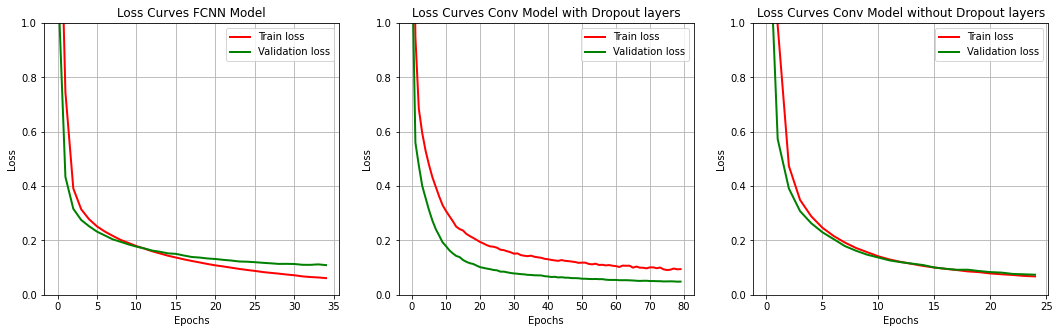

In [ ]:
# Plot losses
figure, axis = plt.subplots(1,3, figsize = (18,5))
axis[0].plot(all_train_loss[0], linewidth = 2.0,  label = "Train loss", color="red")
axis[0].plot(all_val_loss[0],linewidth = 2.0, label = "Validation loss", color = "green")
axis[0].legend(loc="upper right")
axis[0].set_title('Loss Curves FCNN Model')
axis[0].grid()
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel('Loss')
axis[0].set_ylim([0,1])

axis[1].plot(all_train_loss[1], linewidth = 2.0,  label = "Train loss", color="red")
axis[1].plot(all_val_loss[1],linewidth = 2.0, label = "Validation loss", color = "green")
axis[1].legend(loc="upper right")
axis[1].set_title('Loss Curves Conv Model with Dropout layers')
axis[1].grid()
axis[1].set_xlabel('Epochs')
axis[1].set_ylabel('Loss')
axis[1].set_ylim([0,1])

axis[2].plot(all_train_loss[2], linewidth = 2.0,  label = "Train loss", color="red")
axis[2].plot(all_val_loss[2],linewidth = 2.0, label = "Validation loss", color = "green")
axis[2].legend(loc="upper right")
axis[2].set_title('Loss Curves Conv Model without Dropout layers')
axis[2].grid()
axis[2].set_xlabel('Epochs')
axis[2].set_ylabel('Loss')
axis[2].set_ylim([0,1])

plt.show()

In [ ]:
#show the metrics reached by the models
for k in range(0,len(networks)):
  print('MODEL' ,k+1)
  print("  Final train loss:[", all_train_loss[k][len(all_train_loss[k])-1], "] ","Final validation loss: [", all_val_loss[k][len(all_val_loss[k])-1], "]")
  print("  Final train accuracy:[", all_acc_train[k], "] ","Final validation accuracy: [", all_acc_val[k], "]")
  print('\n')

MODEL 1
  Final train loss:[ 0.061331093 ]  Final validation loss: [ 0.10922544 ]
  Final train accuracy:[ 0.98283 ]  Final validation accuracy: [ 0.96825 ]


MODEL 2
  Final train loss:[ 0.094416596 ]  Final validation loss: [ 0.048605513 ]
  Final train accuracy:[ 0.96969 ]  Final validation accuracy: [ 0.98533 ]


MODEL 3
  Final train loss:[ 0.067688584 ]  Final validation loss: [ 0.07390438 ]
  Final train accuracy:[ 0.97917 ]  Final validation accuracy: [ 0.97683 ]




According to the metrics obtained comparing the three models the CNN with dropout seems to lead to better results.<br>
The simple FCNN at a certain point stop to learn and seems to overfit over the train data.<br>
In the same way the CNN without dropout, which seems to learn quickly, at a certain point overfit the data.<br>
For this reason also if the metrics reached by the three models are pretty the same the one selected is the CNN with dropout.

### Models with different optimizer

Starting from the CNN with dropout, now we try different strategies of optimization to see which one is better for this classfication probelm.

In [ ]:
#store the metrics of the previous selected network
conv_drop_train = all_train_loss[1]
conv_drop_val = all_val_loss[1]
conv_drop_acc_train = all_acc_train[1]
conv_drop_acc_val = all_acc_val[1]

In [ ]:
#initialize CNN networks
Ni = 1
Nh1 = 8
Nh2 = 16
Nl1 = Nh2*8*8 
Nl2 = 64
No = 10

conv_drop_opt_SGD = Net(Ni, Nh1, Nh2, Nl1, Nl2, No)
conv_drop_opt_RMS = Net(Ni, Nh1, Nh2, Nl1, Nl2, No)


# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

conv_drop_opt_SGD.to(device)
conv_drop_opt_RMS.to(device)


# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
optimizer_opt_SGD = optim.SGD(conv_drop_opt_SGD.parameters(), lr=1e-3, momentum=0.9)
optimizer_opt_RMS = optim.RMSprop(conv_drop_opt_RMS.parameters(), alpha=0.9, eps=1e-08 ,lr=1e-3 , momentum=0.9)


#create a list which elements point to one of the network created
networks = [conv_drop_opt_SGD, conv_drop_opt_RMS]

#create a list containing the optimizer for each model
optimizers = [optimizer_opt_SGD, optimizer_opt_RMS]

Network initialized
Network initialized
Training device: cuda


In [ ]:
epochs = [50, 10]
all_train_loss = []
all_val_loss = []
all_acc_train = []
all_acc_val = []

for k in range(0,len(networks)):     
    print("MODEL", k+1 ,"\n")
    
    ### TRAINING LOOP
    num_epochs = epochs[k]
    acc_train = 0
    acc_val = 0
    train_loss_log = []
    val_loss_log = []
    for epoch_num in range(num_epochs):
        ### TRAIN
        acc_t = []
        acc_v = []
        train_loss= []
        # Training mode (e.g. enable dropout)
        networks[k].train()
        for sample_batched in train_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            x_batch = x_batch.unsqueeze(1)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = networks[k](x_batch)
            
            # Compute loss
            loss = loss_fn(out, label_batch)

            # Backpropagation
            networks[k].zero_grad()
            loss.backward()

            # Update the weights
            optimizers[k].step()

            # Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)

            #get the accuracy for this batch
            pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
            right = np.sum(pred == np.array(label_batch.cpu()))
            acc_t.append(right)
            
        
        # Save average train loss
        train_loss = np.mean(train_loss)
        train_loss_log.append(train_loss)

        ### VALIDATION
        val_loss= []
        # Evaluation mode (e.g. disable dropout)
        networks[k].eval()
        with torch.no_grad(): # Disable gradient tracking
          for sample_batched in val_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            x_batch = x_batch.unsqueeze(1)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = networks[k](x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)

            #get the accuracy for the val
            pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
            right = np.sum(pred == np.array(label_batch.cpu()))
            acc_v.append(right)

          # Save average validation loss
          val_loss = np.mean(val_loss)
          val_loss_log.append(val_loss)

        acc_train = np.sum(acc_t)/tr_dataset.data.shape[0]
        acc_val = np.sum(acc_v)/val_dataset.data.shape[0]
        print("Epoch", epoch_num + 1, "= Average train loss:[", train_loss, "] ","Accuracy train:[", np.round(acc_train,5),"] " ,"Average validation loss: [", val_loss, "]", "Accuracy validation:[",  np.round(acc_val,5),"]")

    all_train_loss.append(train_loss_log)
    all_val_loss.append(val_loss_log)
    all_acc_train.append(np.round(acc_train,5))
    all_acc_val.append(np.round(acc_val,5))
    print("\n")

MODEL 1 

Epoch 1 = Average train loss:[ 2.3029308 ]  Accuracy train:[ 0.11925 ]  Average validation loss: [ 2.303443 ] Accuracy validation:[ 0.096 ]
Epoch 2 = Average train loss:[ 2.2995732 ]  Accuracy train:[ 0.12506 ]  Average validation loss: [ 2.300284 ] Accuracy validation:[ 0.10908 ]
Epoch 3 = Average train loss:[ 2.2955625 ]  Accuracy train:[ 0.13712 ]  Average validation loss: [ 2.296727 ] Accuracy validation:[ 0.14183 ]
Epoch 4 = Average train loss:[ 2.2905283 ]  Accuracy train:[ 0.14342 ]  Average validation loss: [ 2.292443 ] Accuracy validation:[ 0.16175 ]
Epoch 5 = Average train loss:[ 2.2853172 ]  Accuracy train:[ 0.15275 ]  Average validation loss: [ 2.2871947 ] Accuracy validation:[ 0.16875 ]
Epoch 6 = Average train loss:[ 2.2777967 ]  Accuracy train:[ 0.16267 ]  Average validation loss: [ 2.2806327 ] Accuracy validation:[ 0.17108 ]
Epoch 7 = Average train loss:[ 2.2694495 ]  Accuracy train:[ 0.1749 ]  Average validation loss: [ 2.2724333 ] Accuracy validation:[ 0.1735

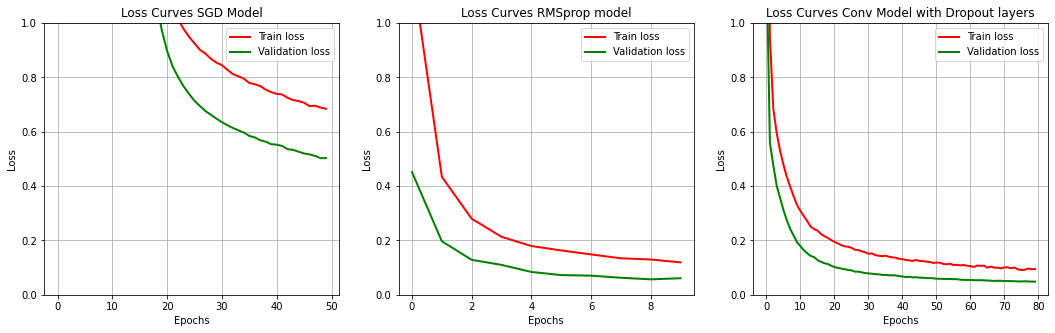

In [ ]:
# Plot losses
figure, axis = plt.subplots(1,3, figsize = (18,5))
axis[0].plot(all_train_loss[0], linewidth = 2.0,  label = "Train loss", color="red")
axis[0].plot(all_val_loss[0],linewidth = 2.0, label = "Validation loss", color = "green")
axis[0].legend(loc="upper right")
axis[0].set_title('Loss Curves SGD Model')
axis[0].grid()
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel('Loss')
axis[0].set_ylim([0,1])

axis[1].plot(all_train_loss[1], linewidth = 2.0,  label = "Train loss", color="red")
axis[1].plot(all_val_loss[1],linewidth = 2.0, label = "Validation loss", color = "green")
axis[1].legend(loc="upper right")
axis[1].set_title('Loss Curves RMSprop model')
axis[1].grid()
axis[1].set_xlabel('Epochs')
axis[1].set_ylabel('Loss')
axis[1].set_ylim([0,1])

axis[2].plot(conv_drop_train, linewidth = 2.0,  label = "Train loss", color="red")
axis[2].plot(conv_drop_val,linewidth = 2.0, label = "Validation loss", color = "green")
axis[2].legend(loc="upper right")
axis[2].set_title('Loss Curves Conv Model with Dropout layers')
axis[2].grid()
axis[2].set_xlabel('Epochs')
axis[2].set_ylabel('Loss')
axis[2].set_ylim([0,1])

plt.show()

In [ ]:
#show the metrics reached by the models
for k in range(0,len(networks)):
  print('MODEL' ,k+1)
  print("  Final train loss:[", all_train_loss[k][len(all_train_loss[k])-1], "] ","Final validation loss: [", all_val_loss[k][len(all_val_loss[k])-1], "]")
  print("  Final train accuracy:[", all_acc_train[k], "] ","Final validation accuracy: [", all_acc_val[k], "]")
  print('\n')

print('MODEL 3')
print("  Final train loss:[", conv_drop_train[len(conv_drop_train)-1], "] ","Final validation loss: [", conv_drop_val[len(conv_drop_val)-1], "]")
print("  Final train accuracy:[", conv_drop_acc_train, "] ","Final validation accuracy: [", conv_drop_acc_val, "]")

MODEL 1
  Final train loss:[ 0.68444616 ]  Final validation loss: [ 0.50291604 ]
  Final train accuracy:[ 0.78131 ]  Final validation accuracy: [ 0.86767 ]


MODEL 2
  Final train loss:[ 0.1192592 ]  Final validation loss: [ 0.06095414 ]
  Final train accuracy:[ 0.96185 ]  Final validation accuracy: [ 0.98208 ]


MODEL 3
  Final train loss:[ 0.094416596 ]  Final validation loss: [ 0.048605513 ]
  Final train accuracy:[ 0.96969 ]  Final validation accuracy: [ 0.98533 ]


##Network Evaluation

We evalute the convolutional network with dropout with Adam as optimizer. It seem to lead to better results.

In [ ]:
loss_mean = []
prediction =[]
true_label = []
acc = 0
#move the input to the GPU and predict the output
for i in range(0,test_dataset.__len__()):
  x = test_dataset.__getitem__(i)[0].to(device)
  y = test_dataset.__getitem__(i)[1].unsqueeze(0).to(device)
  true_label.append(y.cpu()[0])
  conv_drop.eval()
  with torch.no_grad():
      x = x.unsqueeze(0)
      x = x.unsqueeze(0)
      pred = conv_drop(x)
      loss = loss_fn(pred, y)
      loss = loss.detach().cpu().numpy()
      loss_mean.append(loss)

      pred = np.argmax(pred.detach().cpu().numpy(), axis = 1)
      prediction.append(pred)
      right = np.sum(pred == np.array(y.cpu()))
      acc = acc + right
      

loss_mean = np.mean(loss_mean)
print("Test loss MODEL:[", float(loss_mean),"]", " Accuracy of MODEL:[", np.round(acc/len(test_dataset),5),"]")

Test loss MODEL:[ 0.04360423982143402 ]  Accuracy of MODEL:[ 0.9865 ]


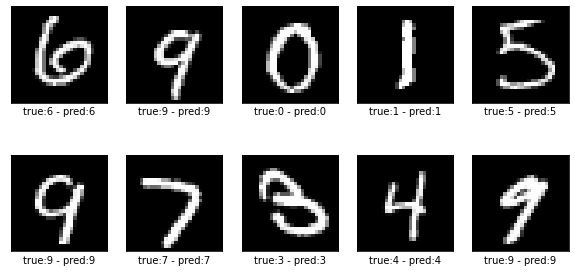

In [ ]:
#example of some predicted samples
plt.figure(figsize=(10,5))

for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    label = 'true:' + str(true_label[i+10].item()) + ' - pred:' + str(prediction[i+10][0])
    plt.imshow(test_dataset.__getitem__(i+10)[0].reshape(width, heigth), cmap='gray')
    plt.xlabel(label)


##Confusion matrix

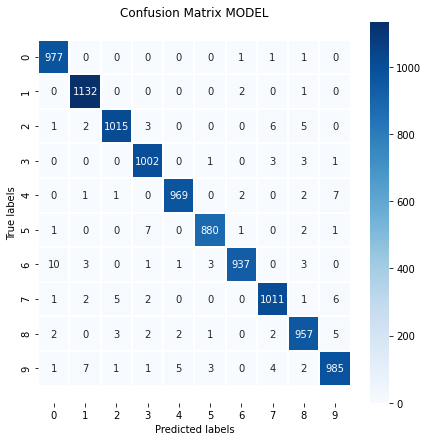

In [ ]:
labels = ['0', '1', '2','3', '4', '5','6', '7', '8','9']
cm = confusion_matrix(true_label, prediction, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

f,ax= plt.subplots(figsize=(7,7))
sas.heatmap(cm, annot=True, ax = ax, linewidths=1, fmt = 'd', cmap = "Blues")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix MODEL')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.show()

##Filters and Feature maps

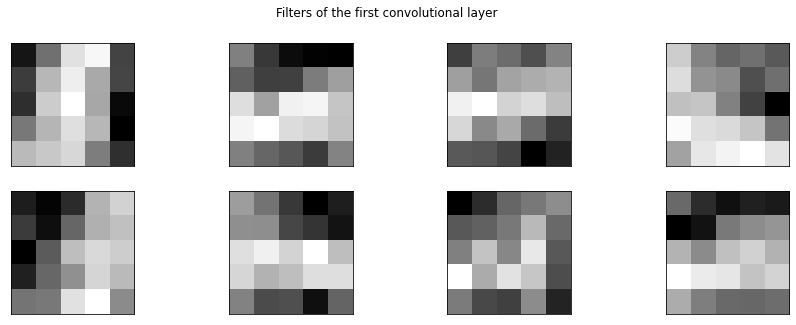

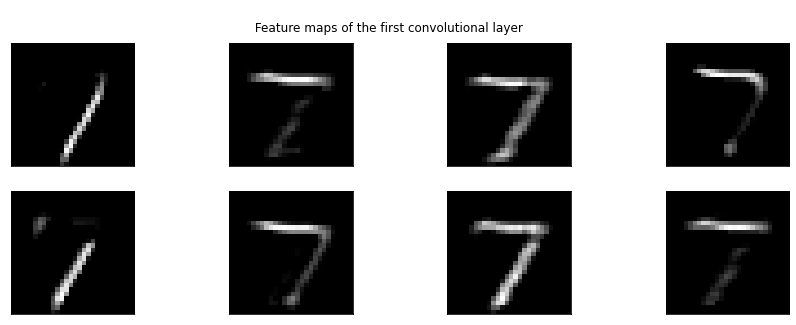

In [ ]:
#first we collect the filters of the first convolutional layer 
#these are 8 as the number of neurons of the layer
filters_1 = conv_drop.fc1.weight
filters_1 = torch.squeeze(filters_1,1)

filters_1  = filters_1.cpu().detach().numpy()

#get the feature maps generated by the first convolutional layer
#this are generated using the first image of the test set
#we expect 8 different featur maps  

features = []
input = test_dataset.__getitem__(0)[0].unsqueeze(0).unsqueeze(0).to(device)

#define a funcion that return the squeezed output of the called layer
def get_features_map(self, input, output):
    features.append(output.squeeze(0))

#used the method register_forward_hook to get the features maps
hook_handle = conv_drop.fc1.register_forward_hook(get_features_map)
conv_drop.eval()
out = conv_drop(input)
### Remove hook
hook_handle.remove()

#plot the filters and their relative feature maps for the first sample of the test_dataset
plt.figure(figsize=(15,5))
for i in range(1, 9):
    plt.subplot(2,4,i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(filters_1[i-1], cmap='gray')
plt.suptitle('Filters of the first convolutional layer') 


act = nn.ReLU()

plt.figure(figsize=(15,5))
for i in range(1, 9):
    plt.subplot(2,4,i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(act(features[0][i-1]).cpu().detach().numpy(), cmap='gray')
plt.suptitle('\n Feature maps of the first convolutional layer') 
plt.show()

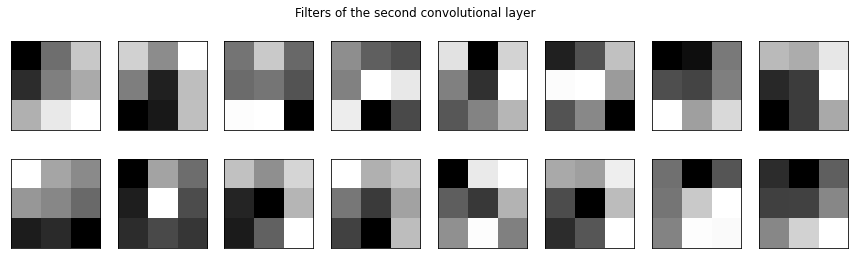

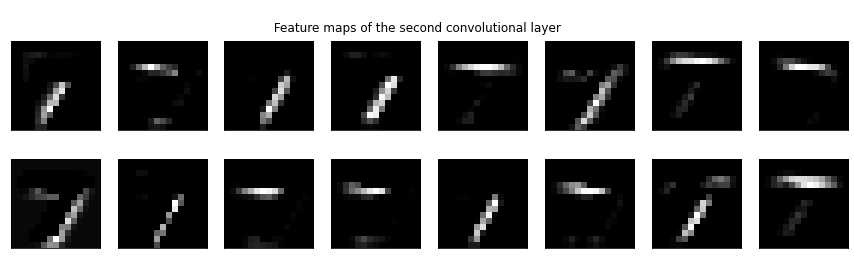

In [ ]:
#first we collect the filters of the first convolutional layer 
#these are 16 as the number of neurons of the layer
filters_2 = conv_drop.fc2.weight
filters_2 = torch.squeeze(filters_2,1)

filters_2  = filters_2.cpu().detach().numpy()

features_2 = []
input = test_dataset.__getitem__(0)[0].unsqueeze(0).unsqueeze(0).to(device)

#define a function that return the squeezed output of the called layer
def get_features_map(self, input, output):
    features_2.append(output.squeeze(0))

#used the method register_forward_hook to get the features maps
hook_handle = conv_drop.fc2.register_forward_hook(get_features_map)
conv_drop.eval()
out = conv_drop(input)
### Remove hook
hook_handle.remove()


plt.figure(figsize=(15,4))
for i in range(1, 17):
    plt.subplot(2,8,i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(filters_2[i-1][0], cmap='gray')
plt.suptitle('Filters of the second convolutional layer') 

act = nn.ReLU()

plt.figure(figsize=(15,4))
for i in range(1, 17):
    plt.subplot(2,8,i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(act(features_2[0][i-1]).cpu().detach().numpy(), cmap='gray')
plt.suptitle('\n Feature maps of the second convolutional layer') 
plt.show()

In [ ]:
#create an image with random uniform distributed noise
img = np.uint8(np.random.uniform(0, 255, (width, heigth, 1)))/255

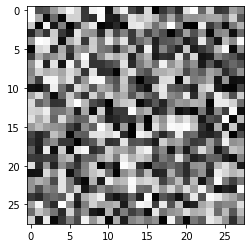

In [ ]:
#show the generated noisy image
plt.imshow(img.squeeze(2),cmap = "gray")

In [ ]:
img = torch.tensor(img.swapaxes(0, 2)).unsqueeze(0).float().to(device)
img = img.clone().detach().requires_grad_(True)

y = []
act = nn.Softmax(dim=1)

# Define optimizer for the image
optimizer1 = optim.Adam([img], lr=0.01)


conv_drop.eval()
for i in range(0,150):
    
    output = conv_drop(img)

    # Target specific class
    class_loss = -output[0, 0]
    
    # Zero grads
    conv_drop.zero_grad()
    # Backward
    class_loss.backward()
    # Update image
    optimizer1.step()

    if i%10 == 0:
      y.append(img.cpu())

Softmax result of the interested class over the last ouput:  1.0


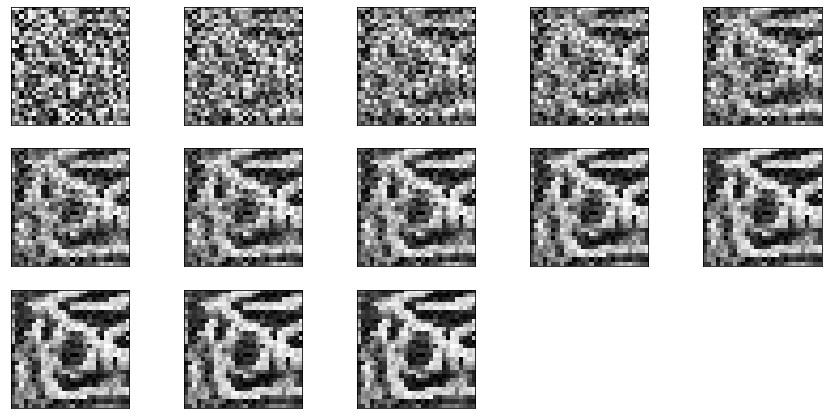

In [ ]:
plt.figure(figsize=(15,10))

for i in range(1, len(y)-1):
    plt.subplot(4,5,i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(y[i-1].squeeze(0).squeeze(0).detach().numpy()*255, cmap='gray')


print("Softmax result of the interested class over the last ouput: ", act(output)[0][0].item())